In [1]:
import sys

if "./" not in sys.path:
    sys.path.append("./")
from utils.share import *
import utils.config as config

import einops
import numpy as np
import cv2
import torch
from pytorch_lightning import seed_everything

from annotator.util import resize_image, HWC3

from annotator.canny import CannyDetector
from annotator.uniformer import UniformerDetector
from annotator.content import ContentDetector
from models.util import create_model, load_state_dict
from models.ddim_hacked import DDIMSampler

model = create_model("/data/maryam.sana/vimeo_unicontrol/Uni-ControlNet/configs/vimeo/uni_v15.yaml").cpu()
model.load_state_dict(load_state_dict("/data/maryam.sana/vimeo_unicontrol/Uni-ControlNet/checkpoints/vimeo/uni_v15.ckpt", location="cuda"))
model = model.cuda()
ddim_sampler = DDIMSampler(model)
apply_canny = CannyDetector()
apply_seg = UniformerDetector()
apply_content = ContentDetector()

/data/maryam.sana/anaconda3/envs/unicontrol/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/maryam.sana/anaconda3/envs/unicontrol/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


logging improved.
Enabled sliced_attention.
UniControlNet: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEffic

In [2]:
def process(
    canny_image,
    seg_image,
    prompt,
    a_prompt,
    n_prompt,
    num_samples,
    image_resolution,
    ddim_steps,
    strength,
    scale,
    seed,
    eta,
    global_strength,
    content_image=None,
    low_threshold=100,
    high_threshold=200
):

    seed_everything(seed)

    with torch.no_grad():
        W, H = image_resolution, image_resolution

        canny_image = cv2.resize(canny_image, (W, H))
        canny_detected_map = HWC3(canny_image)

        seg_image = cv2.resize(seg_image, (W, H))
        seg_detected_map = HWC3(seg_image)

        if content_image is not None:
            content_emb = apply_content(content_image)
        else:
            content_emb = np.zeros((768))

        detected_maps = np.concatenate([canny_detected_map, seg_detected_map], axis=2)

        local_control = torch.from_numpy(detected_maps.copy()).float().cuda() / 255.0
        local_control = torch.stack([local_control for _ in range(num_samples)], dim=0)
        local_control = einops.rearrange(local_control, "b h w c -> b c h w").clone()
        global_control = torch.from_numpy(content_emb.copy()).float().cuda().clone()
        global_control = torch.stack([global_control for _ in range(num_samples)], dim=0)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        uc_local_control = local_control
        uc_global_control = torch.zeros_like(global_control)
        cond = {
            "local_control": [local_control],
            "c_crossattn": [
                model.get_learned_conditioning([prompt + ", " + a_prompt] * num_samples)
            ],
            "global_control": [global_control],
        }
        un_cond = {
            "local_control": [uc_local_control],
            "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)],
            "global_control": [uc_global_control],
        }
        shape = (4, H // 8, W // 8)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=True)

        model.control_scales = [strength] * 13
        samples, _ = ddim_sampler.sample(
            ddim_steps,
            num_samples,
            shape,
            cond,
            verbose=True,
            eta=eta,
            unconditional_guidance_scale=scale,
            unconditional_conditioning=un_cond,
            global_strength=global_strength,
        )

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        x_samples = model.decode_first_stage(samples)
        x_samples = (
            (einops.rearrange(x_samples, "b c h w -> b h w c") * 127.5 + 127.5)
            .cpu()
            .numpy()
            .clip(0, 255)
            .astype(np.uint8)
        )
        results = [x_samples[i] for i in range(num_samples)]

    return (results, [canny_detected_map, seg_detected_map])


In [3]:
import cv2
import glob

image_paths = ['data/00096_0576/im1.png', 'data/00096_0576/im2.png', 'data/00096_0576/im3.png', 'data/00096_0576/im4.png', 'data/00096_0576/im5.png', 'data/00096_0576/im6.png', 'data/00096_0576/im7.png']
canny_paths = sorted(glob.glob('data/00096_0576_processed/decompressed/canny/*.png'))
seg_paths = sorted(glob.glob('data/00096_0576_processed/decompressed/seg/*.png'))

prompt = 'a girl with black hair and black shirt standing infront grey and blue background '

# Load original images
original_images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in image_paths]

# Load Canny images
canny_images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in canny_paths]

# Load segmentation images
seg_images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in seg_paths]

Global seed set to 42


Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.89298052 0.86737001 0.84038192 0.81210774 0.78265446 0.75214338
 0.72070938 0.68849909 0.65566933 0.62238538 0.58881873 0.55514455
 0.52153981 0.4881804  0.45523876 0.42288151 0.39126703 0.36

DDIM Sampler: 100%|███| 50/50 [00:12<00:00,  4.10it/s]
Global seed set to 42


(512, 512, 3)
Saved prediction image: data/00096_0576/preds_cs/im1_pred.png
Saved residue image: data/00096_0576/residues_cs/im1_residue.png
Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.89298052 0.86737001 0.84038192 0.81210774 0.782654

DDIM Sampler: 100%|███| 50/50 [00:12<00:00,  4.07it/s]
Global seed set to 42


(512, 512, 3)
Saved prediction image: data/00096_0576/preds_cs/im2_pred.png
Saved residue image: data/00096_0576/residues_cs/im2_residue.png
Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.89298052 0.86737001 0.84038192 0.81210774 0.782654

DDIM Sampler: 100%|███| 50/50 [00:12<00:00,  4.06it/s]
Global seed set to 42


(512, 512, 3)
Saved prediction image: data/00096_0576/preds_cs/im3_pred.png
Saved residue image: data/00096_0576/residues_cs/im3_residue.png
Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.89298052 0.86737001 0.84038192 0.81210774 0.782654

DDIM Sampler: 100%|███| 50/50 [00:12<00:00,  4.03it/s]
Global seed set to 42


(512, 512, 3)
Saved prediction image: data/00096_0576/preds_cs/im4_pred.png
Saved residue image: data/00096_0576/residues_cs/im4_residue.png
Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.89298052 0.86737001 0.84038192 0.81210774 0.782654

DDIM Sampler: 100%|███| 50/50 [00:12<00:00,  4.00it/s]
Global seed set to 42


(512, 512, 3)
Saved prediction image: data/00096_0576/preds_cs/im5_pred.png
Saved residue image: data/00096_0576/residues_cs/im5_residue.png
Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.89298052 0.86737001 0.84038192 0.81210774 0.782654

DDIM Sampler: 100%|███| 50/50 [00:12<00:00,  3.98it/s]
Global seed set to 42


(512, 512, 3)
Saved prediction image: data/00096_0576/preds_cs/im6_pred.png
Saved residue image: data/00096_0576/residues_cs/im6_residue.png
Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.89298052 0.86737001 0.84038192 0.81210774 0.782654

DDIM Sampler: 100%|███| 50/50 [00:12<00:00,  3.99it/s]


(512, 512, 3)
Saved prediction image: data/00096_0576/preds_cs/im7_pred.png
Saved residue image: data/00096_0576/residues_cs/im7_residue.png


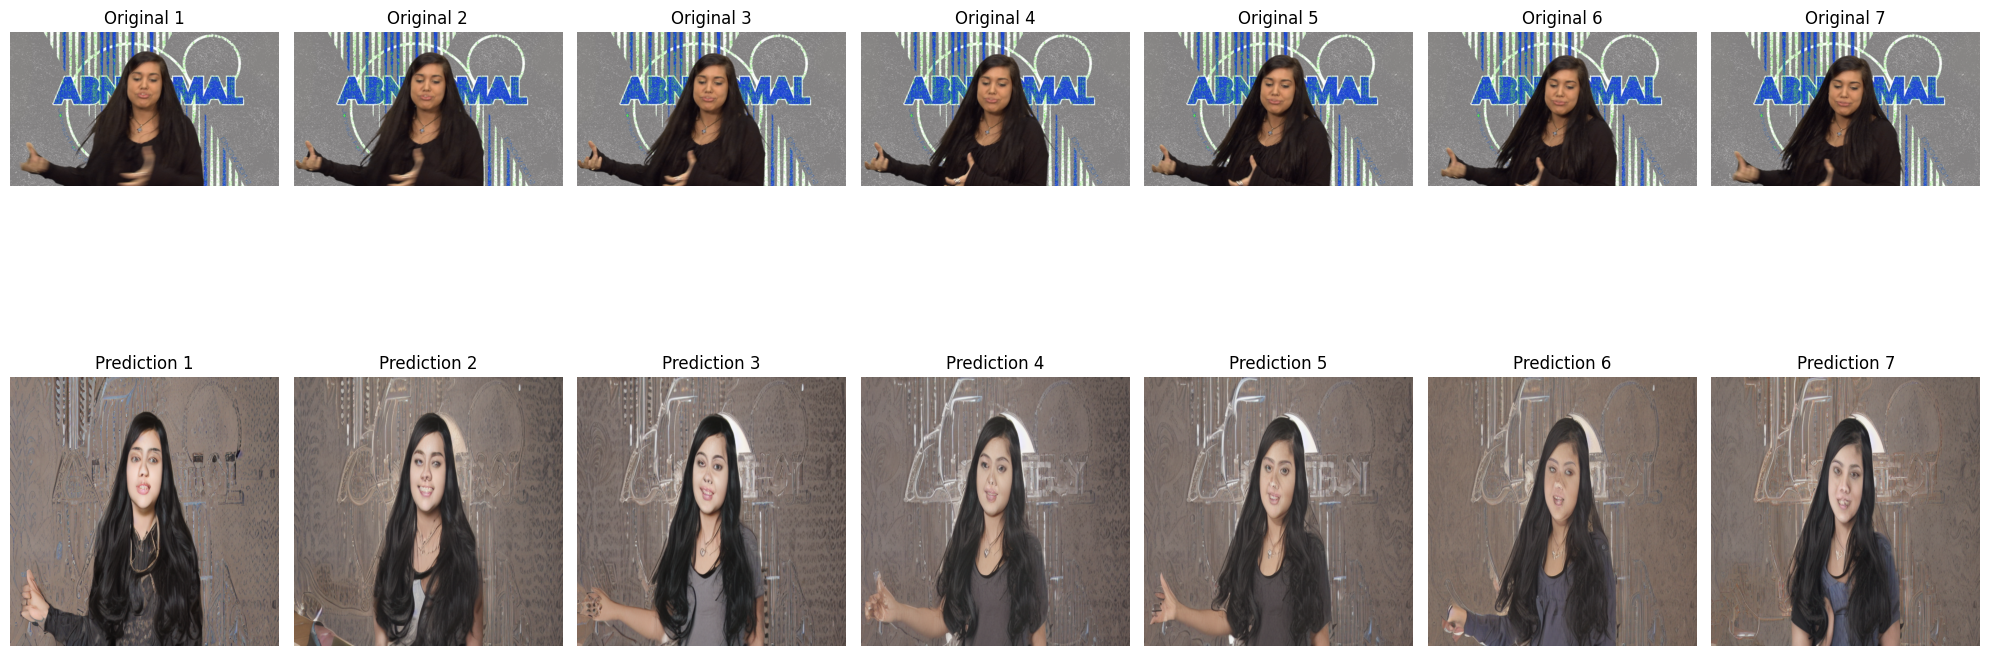

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from test_utils import calculate_metrics

# Define the folders for saving predictions and residues
pred_folder = 'data/00096_0576/preds_cs'
residue_folder = 'data/00096_0576/residues_cs'

# Ensure the directories exist
os.makedirs(residue_folder, exist_ok=True)
os.makedirs(pred_folder, exist_ok=True)

residues = []
predictions = []

for i, (canny_image, seg_image) in enumerate(zip(canny_images, seg_images)):
        # Resize original images to 512x512
    original_image = original_images[i]

    # Run the process function
    pred_images, detected_maps = process(
        canny_image=canny_image,
        seg_image=seg_image,
        prompt=prompt,
        a_prompt="best quality, extremely detailed",
        n_prompt="longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality",
        num_samples=1,
        image_resolution=512,
        ddim_steps=50,
        strength=1,
        scale=7.5,
        seed=42,
        eta=0.0,
        global_strength=1
    )

    pred_img = pred_images[0]   
    print(pred_img.shape)
    # Resize original_image to match the size of pred_img
    if original_image.shape != pred_img.shape:
        original_image = cv2.resize(original_image, (pred_img.shape[1], pred_img.shape[0]))
    
    # Calculate the residue
    residue = original_image - pred_img 
    
    # Append the prediction and residue
    predictions.append(pred_img)
    residues.append(residue)
    
    # Save prediction image
    pred_image_path = os.path.join(pred_folder, f"im{i+1}_pred.png")
    cv2.imwrite(pred_image_path, cv2.cvtColor(pred_img, cv2.COLOR_RGB2BGR))
    print(f"Saved prediction image: {pred_image_path}")

    # Save residue image
    residue_image_path = os.path.join(residue_folder, f"im{i+1}_residue.png")
    cv2.imwrite(residue_image_path, cv2.cvtColor(residue, cv2.COLOR_RGB2BGR))
    print(f"Saved residue image: {residue_image_path}")

fig, axes = plt.subplots(2, len(original_images), figsize=(20, 10))
for i in range(len(original_images)):
    axes[0, i].imshow(original_images[i])
    axes[0, i].set_title(f"Original {i + 1}")
    axes[0, i].axis('off')
    axes[1, i].imshow(predictions[i])
    axes[1, i].set_title(f"Prediction {i + 1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [7]:
from PIL import Image

psnr_values = []
mssim_values = []

for orig_img, pred_img in zip(original_images, predictions):
    # Convert to PIL images for metric calculation
    orig_pil = Image.fromarray(orig_img)
    pred_pil = Image.fromarray(pred_img)
    
    # Calculate metrics
    psnr_value, mssim_value = calculate_metrics(orig_pil, [pred_pil])
    
    # Store the results
    psnr_values.append(psnr_value)
    mssim_values.append(mssim_value)
    
    # print(f"PSNR: {psnr_value:.2f}, MS-SSIM: {mssim_value:.4f}")

# Calculate mean PSNR and MS-SSIM
mean_psnr = np.mean(psnr_values)
mean_mssim = np.mean(mssim_values)

print(f"\nMean PSNR: {mean_psnr:.2f}")
print(f"Mean MS-SSIM: {mean_mssim:.4f}")


Mean PSNR: 14.26
Mean MS-SSIM: 0.4387


In [10]:
## after video prediction we evaluate codec (meaning adding residue)

decompressed_residue_paths = glob.glob('data/00096_0576/residues_cs/*.png.tfci.png')
preds_paths = glob.glob('data/00096_0576/preds_cs/*.png')

residues = [cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) for image_path in decompressed_residue_paths]
preds = [cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) for image_path in preds_paths]

psnr_values = []
mssim_values = []
reconstructions = []
for pred,residue,original_image in zip(preds,residues,original_images):
    recons_img = pred+residue
    if original_image.shape != pred.shape:
        original_image = cv2.resize(original_image, (pred.shape[1], pred.shape[0]))
    orig_pil = Image.fromarray(original_image)
    recons_pil = Image.fromarray(recons_img)
    reconstructions.append(recons_img)
    
    # Calculate metrics
    psnr_value, mssim_value = calculate_metrics(orig_pil, [recons_pil])
    
    # Store the results
    psnr_values.append(psnr_value)
    mssim_values.append(mssim_value)

# Calculate mean PSNR and MS-SSIM
mean_psnr = np.mean(psnr_values)
mean_mssim = np.mean(mssim_values)

print(f"\nMean PSNR: {mean_psnr:.2f}")
print(f"Mean MS-SSIM: {mean_mssim:.4f}")


Mean PSNR: 13.70
Mean MS-SSIM: 0.5823


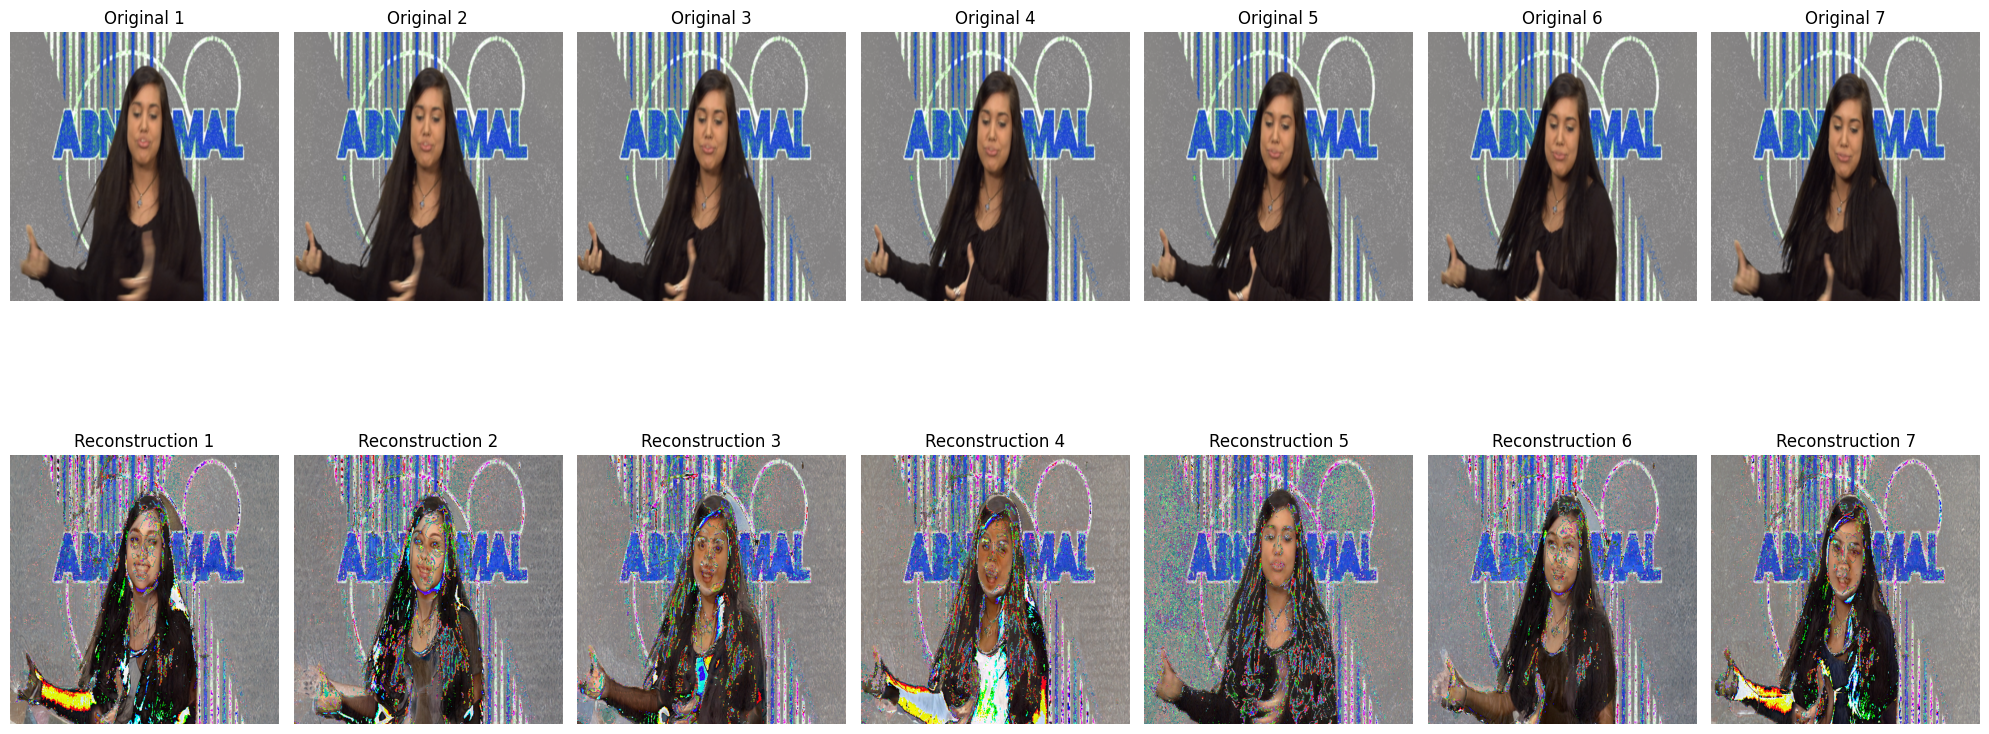

In [11]:
# Display the original and reconstructed images
num_images = len(reconstructions)
fig, axs = plt.subplots(2, num_images, figsize=(20, 10))

for i in range(num_images):
    # Resize original images to match the reconstructed image size
    original_resized = cv2.resize(original_images[i], (reconstructions[i].shape[1], reconstructions[i].shape[0]))

    # Display original images
    axs[0, i].imshow(original_resized)
    axs[0, i].set_title(f"Original {i + 1}")
    axs[0, i].axis('off')

    # Display reconstructed images
    axs[1, i].imshow(reconstructions[i])
    axs[1, i].set_title(f"Reconstruction {i + 1}")
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()
